In [ ]:
import os

import pandas as pd
import numpy as np

# store elements as dictionary keys and their counts as dictionary values
from collections import Counter

# scikit-learn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline

# Classification metrics
from sklearn.metrics import confusion_matrix, classification_report

# Function for creating model pipelines - sklearn
from sklearn.pipeline import make_pipeline

# Function for creating model pipelines - imblearn
from imblearn.pipeline import make_pipeline as imbl_pipe

# Over-sampling using SMOTE
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [ ]:
abt = pd.read_csv("https://raw.githubusercontent.com/SumantaSethi/Customer-Churn-Prediction-/master/Resources/Analytical_Base_Table.csv")
abt.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Model Training

Splitting dataframe into separate objects:

x for the input features

y for the target variable

In [ ]:
#Separate dataframe into separate object

# Object for target variable
y = abt.Exited

# object for input features
X = abt.drop(['Exited'], axis=1)

# display shapes of X and y
print(X.shape, y.shape)

(10000, 10) (10000,)


In [ ]:
# List numerical features
num_columns = X.select_dtypes(include='number').columns.tolist()
num_columns

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [ ]:
# List categorical features
cat_columns = X.select_dtypes(include='object').columns.tolist()
cat_columns

['Geography', 'Gender']

In [ ]:
def class_count(a):
    counter=Counter(a)
    kv=[list(counter.keys()),list(counter.values())]
    abt2 = pd.DataFrame(np.array(kv).T, columns=['Exited','Count'])
    abt2['Count'] = abt2['Count'].astype('int64')
    abt2['%'] = round(abt2['Count'] / a.shape[0] * 100, 2)
    return abt2.sort_values('Count',ascending=False)

In [ ]:
class_count(y)

,Exited,Count,%
1,0,7963,79.63
0,1,2037,20.37


# Split the data

Splitting our data into separate training and test sets

training set(70%): to teach the model

testing set(30%): to evaluate performance

In [ ]:
random_state = 10

# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=random_state,
                                                    stratify=abt.Exited)

# Print number of observations in X_train, X_test, y_train, and y_test
print(len(X_train), len(X_test), len(y_train), len(y_test))

7000 3000 7000 3000


In [ ]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

Shape of X_train: (7000, 10)
Shape of X_test: (3000, 10)


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7000 entries, 8061 to 4741
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      7000 non-null   int64  
 1   Geography        7000 non-null   object 
 2   Gender           7000 non-null   object 
 3   Age              7000 non-null   int64  
 4   Tenure           7000 non-null   int64  
 5   Balance          7000 non-null   float64
 6   NumOfProducts    7000 non-null   int64  
 7   HasCrCard        7000 non-null   int64  
 8   IsActiveMember   7000 non-null   int64  
 9   EstimatedSalary  7000 non-null   float64
dtypes: float64(2), int64(6), object(2)
memory usage: 601.6+ KB


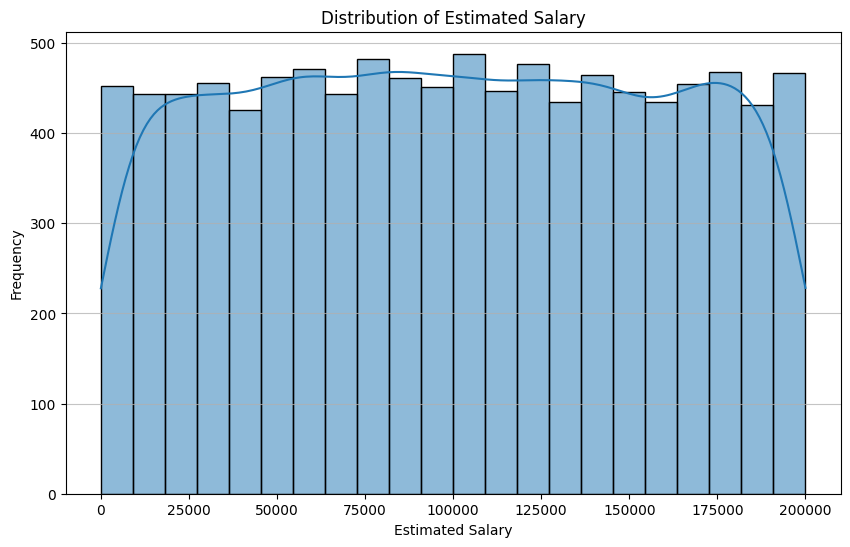

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(abt['EstimatedSalary'], kde=True)
plt.title('Distribution of Estimated Salary')
plt.xlabel('Estimated Salary')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Preprocessing pipeline

Scale numerical data and encode categorical data

MinMaxScaler and OneHotEncoder Create lists of indexes from the list of column namesNeed to be numeric not string to specify columns name in column transformer

In [ ]:
num_features = []

for i in num_columns:
    location = X.columns.get_loc(i)
    num_features.append(location)
print(num_features)

[0, 3, 4, 5, 6, 7, 8, 9]


In [ ]:
cat_features = []

for i in cat_columns:
    location = X.columns.get_loc(i)
    cat_features.append(location)
print(cat_features)

[1, 2]


In [ ]:
# Define column transformer
# Need to be numeric not string to specify columns name
preprocess = make_column_transformer(
    (MinMaxScaler(), num_features),
    (OneHotEncoder(sparse_output=False), cat_features)
)
preprocess

ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                 [0, 3, 4, 5, 6, 7, 8, 9]),
                                ('onehotencoder',
                                 OneHotEncoder(sparse_output=False), [1, 2])])

In [ ]:
# Import classifier
from sklearn.neighbors import KNeighborsClassifier

# Define model with pipeline
model = imbl_pipe(preprocess,
                  SMOTE(sampling_strategy='auto', random_state=random_state),
                  KNeighborsClassifier())

model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  [0, 3, 4, 5, 6, 7, 8, 9]),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  [1, 2])])),
                ('smote', SMOTE(random_state=10)),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [ ]:
# Create the GridSearchCV model
# Create the GridSearch estimator along with a parameter object containing the values to adjust
from sklearn.model_selection import GridSearchCV
kn_param_grid = {
    'kneighborsclassifier__n_neighbors' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    'kneighborsclassifier__weights' : ['uniform', 'distance'],
    'kneighborsclassifier__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']
}
kn_grid = GridSearchCV(model, kn_param_grid, verbose=3, cv= 5, scoring='accuracy')

In [ ]:
kn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV 1/5] END kneighborsclassifier__algorithm=auto, kneighborsclassifier__n_neighbors=1, kneighborsclassifier__weights=uniform;, score=0.759 total time=   0.1s
[CV 2/5] END kneighborsclassifier__algorithm=auto, kneighborsclassifier__n_neighbors=1, kneighborsclassifier__weights=uniform;, score=0.759 total time=   0.1s
[CV 3/5] END kneighborsclassifier__algorithm=auto, kneighborsclassifier__n_neighbors=1, kneighborsclassifier__weights=uniform;, score=0.758 total time=   0.1s
[CV 4/5] END kneighborsclassifier__algorithm=auto, kneighborsclassifier__n_neighbors=1, kneighborsclassifier__weights=uniform;, score=0.751 total time=   0.1s
[CV 5/5] END kneighborsclassifier__algorithm=auto, kneighborsclassifier__n_neighbors=1, kneighborsclassifier__weights=uniform;, score=0.751 total time=   0.1s
[CV 1/5] END kneighborsclassifier__algorithm=auto, kneighborsclassifier__n_neighbors=1, kneighborsclassifier__weights=distance;, score=0.759 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         [0, 3,
                                                                          4, 5,
                                                                          6, 7,
                                                                          8,
                                                                          9]),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(sparse_output=False),
                                                                         [1,
                                                                          2])])),
                                       ('smote', SMOTE(random_state=10)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__algorithm': ['auto',
                                                             'ball_tree',
                                                             'kd_tree',
                                                             'brute'],
                         'kneighborsclassifier__n_neighbors': [1, 2, 3, 4, 5, 6,
                                                               7, 8, 9, 10, 11,
                                                               12, 13, 14, 15,
                                                               16, 17, 18, 19,
                                                               20, 21, 22, 23,
                                                               24, 25, 26, 27,
                                                               28, 29, 30],
                         'kneighborsclassifier__weights': ['uniform',
                                                           'distance']},
             scoring='accuracy', verbose=3)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Get the best model from GridSearchCV
best_knn_model = kn_grid.best_estimator_

# Make predictions on the test set
y_pred = best_knn_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      2389
           1       0.47      0.44      0.46       611

    accuracy                           0.78      3000
   macro avg       0.66      0.66      0.66      3000
weighted avg       0.78      0.78      0.78      3000


Accuracy Score:
0.7836666666666666


In [ ]:
print(kn_grid.best_score_)

0.774


In [ ]:
print(f"Training Data Score: {kn_grid.score(X_train, y_train)}")
print(f"Testing Data Score: {kn_grid.score(X_test, y_test)}")

Training Data Score: 0.9921428571428571
Testing Data Score: 0.7836666666666666


In [ ]:
predictions = kn_grid.predict(X_test)
print(f"First 10 Predictions:   {predictions[:10]}")
print(f"First 10 Actual labels: {y_test[:10].tolist()}")

First 10 Predictions:   [1 0 0 0 0 1 0 0 0 0]
First 10 Actual labels: [1, 0, 0, 0, 0, 1, 0, 0, 0, 0]


In [ ]:
pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)

,Prediction,Actual
0,1,1
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
2995,0,0
2996,0,0
2997,0,0
2998,0,0


In [ ]:
cm = confusion_matrix(y_test, predictions)
print(cm)

[[2080  309]
 [ 340  271]]


In [ ]:
cm = np.around(cm / cm.sum(axis=1)[:, np.newaxis], 2)
print(cm)

[[0.87 0.13]
 [0.56 0.44]]


In [ ]:
pred = kn_grid.predict(X_test[:1])

In [ ]:
print(f"Predicted classes: {pred}")
print(f"Actual Labels: {list(y_test[:1])}")

Predicted classes: [1]
Actual Labels: [1]


In [ ]:
import joblib

filename = 'Knn.sav'
joblib.dump(kn_grid, filename)

['Knn.sav']

In [ ]:
kn_model = joblib.load(filename)
print(kn_model.score(X_test, y_test))

0.7836666666666666
